# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images issues de Google Quickdraw (https://quickdraw.withgoogle.com/data).
Le jeu de données proposé comprend 5 classes balancées, avec 15000 exemples d'apprentissage et 5000 exemples de validation : des paniers, des yeux, des lunettes, des lapins et des mains.

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur la base originale que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous expliquerez votre démarche, justifierez vos choix, commenterez vos expérimentations et vos résultats.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. Les binômes seront classés par taux de reconnaissance décroissant, les premiers ayant 8 points accordés, les autres binômes ayant une note suivant une décroissance linéaire.

Le notebook sera déposé sur la plateforme moodle du cours.

## Imports

In [20]:
import tensorflow
import pandas as pd
import time
import os
import numpy as np
from PIL import Image
import glob
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#print(tensorflow.version.VERSION)
# Ajouter les imports nécessaires

## Données

In [2]:
classes = ["basket","eye","binoculars","rabbit","hand"]
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

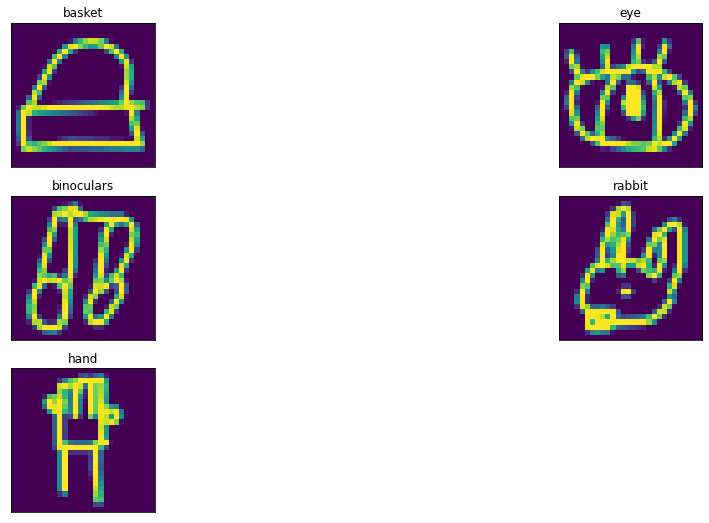

In [3]:
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv", skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    


## Chargement des données pour l'entraînement

On utilise le module `pandas`, il facilite grandement le chargement de fichier CSV, en les lisant sous-forme de matrices appelées **Dataframes**.

L'utilisation du paramètre `dtype` est obligatoire pour indiquer à `pandas` de charger le contenu des cases sous la forme de chaînes de caractères. Cela évite une transformation pour obtenir les étiquettes des classes qui doit obligatoirement être de ce type là.

In [4]:
datas = pd.read_csv("train.csv", dtype="str")
print(datas)

              image_name             relative_path class_label
0      basket_052681.png  basket/basket_052681.png           0
1      basket_028248.png  basket/basket_028248.png           0
2      basket_050738.png  basket/basket_050738.png           0
3      basket_034414.png  basket/basket_034414.png           0
4      basket_091738.png  basket/basket_091738.png           0
...                  ...                       ...         ...
74995    hand_241467.png      hand/hand_241467.png           4
74996    hand_052619.png      hand/hand_052619.png           4
74997    hand_168727.png      hand/hand_168727.png           4
74998    hand_285523.png      hand/hand_285523.png           4
74999    hand_263562.png      hand/hand_263562.png           4

[75000 rows x 3 columns]


## Génération de données

Nous utilisons l'outil de génération de données `ImageDataGenerator`pour faciliter la manipulation du Dataframe.
Grâce à l'option `validation_split`, nous conservons **20%** des données d'entraînement pour les utiliser lors de la validation du modèle.

In [5]:
# 20% des données sont utilisées pour la validation
trainImageGenerator = ImageDataGenerator(
    validation_split=0.2
)

## Désordonner le Dataframe

L'`ImageDataGenerator` étant utilisé pour séparer les données d'entraînement des données de validation, nous sommmes obligés de manuellement réordonner le Dataframe. Si nous ne le faisions pas, seules la fin du Dataframe serait utilisée pour la validation. Dans le cas du 20% de données de validation, cela signifie que les images de la catégorie *hand* serait utilisée pour valider les résultats d'un modèle entrainait uniquement sur les catégories : *eye*, *basket*, *binoculars* et *rabbit*.

In [6]:
datas = datas.sample(frac=1).reset_index(drop=True)

## Modèle



In [7]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(28, 28)), # Résolution des images
        keras.layers.Reshape((28, 28, 1)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(5, activation='softmax')
    ]
)

## Compilation du modèle

### Optimizer
### Loss
### Metrics

In [8]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 4

## Répartition des données

In [9]:
# Images utilisées pour l'entrainement
train_images = trainImageGenerator.flow_from_dataframe(
    dataframe=datas, # Données provenant de pandas
    directory="images", # Dossier racine des images
    x_col="relative_path", # Chemin d'acces des images
    y_col="class_label", # Nom des classes 
    class_mode="categorical", # Type de classification : 
    target_size=(28,28),
    color_mode="grayscale",
    subset="training",
    batch_size=1000,
    validate_filenames=False
)

# Images utilisées pour la validation
validation_images = trainImageGenerator.flow_from_dataframe(
    dataframe=datas, 
    directory="images",
    x_col="relative_path",
    y_col="class_label",
    class_mode="categorical",
    target_size=(28,28),
    color_mode="grayscale",
    subset="validation",
    batch_size=1000,
    validate_filenames=False
)

Found 60000 non-validated image filenames belonging to 5 classes.
Found 15000 non-validated image filenames belonging to 5 classes.


## Entrainement du modèle

### Données à utiliser
### Nombre d'epochs

In [10]:
history = model.fit(train_images, validation_data=validation_images, epochs=5, verbose=1)

Epoch 1/5
60/60 [==============================] - 18s 303ms/step - loss: 6.0035 - categorical_accuracy: 0.6189 - val_loss: 0.5593 - val_categorical_accuracy: 0.8160
Epoch 2/5
60/60 [==============================] - 12s 195ms/step - loss: 0.5097 - categorical_accuracy: 0.8347 - val_loss: 0.4197 - val_categorical_accuracy: 0.8658
Epoch 3/5
60/60 [==============================] - 12s 196ms/step - loss: 0.4140 - categorical_accuracy: 0.8676 - val_loss: 0.3705 - val_categorical_accuracy: 0.8817
Epoch 4/5
60/60 [==============================] - 12s 194ms/step - loss: 0.3639 - categorical_accuracy: 0.8845 - val_loss: 0.3307 - val_categorical_accuracy: 0.8963
Epoch 5/5
60/60 [==============================] - 12s 195ms/step - loss: 0.3298 - categorical_accuracy: 0.8947 - val_loss: 0.3092 - val_categorical_accuracy: 0.9045


## Affichage des résultats

<function matplotlib.pyplot.show(close=None, block=None)>

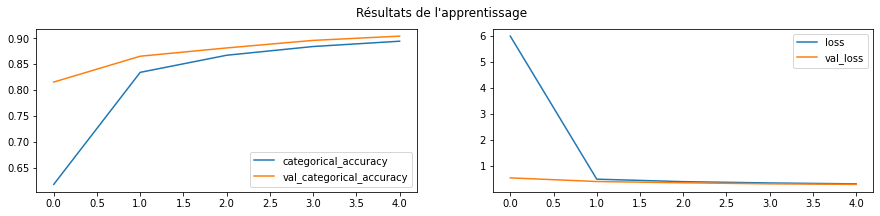

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
fig.suptitle("Résultats de l'apprentissage")
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.legend(['categorical_accuracy', 'val_categorical_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['loss', 'val_loss'])
plt.show


## Exemple de classification par le modèle

Pour afficher quelques exemples nous allons réutiliser les données utilisées lors de la validation. On demande au modèle de prédire la classe des images, puis on extrait une partie de ces résultats. Enfin on affiche le résultat après l'avoir convertie en texte plus explicite.

In [23]:
classes = ["basket", "eye", "binoculars", "rabbit", "hand"]
prediction = model.predict(validation_images)
prediction = np.argmax(prediction, axis = 1)[:10] 
pprint(["{} ({})".format(classes[pred], pred) for pred in prediction])


['rabbit (3)',
 'hand (4)',
 'basket (0)',
 'hand (4)',
 'rabbit (3)',
 'hand (4)',
 'rabbit (3)',
 'binoculars (2)',
 'basket (0)',
 'hand (4)']


## Sauvegarde du modèle

On utilise le format **HDF5** pour stocker le modèle, ce format est pratique car il permet de stocker l'architecture du modèle, les poids ainsi que les informations de compilation du modèle.

In [13]:
model.save("pouly_zangla_classifier.h5")